# Data Understanding
In this notebook I am going to to take a look at the Boston AirBnB data: https://www.kaggle.com/airbnb/boston. My goal is to explore some basic trends in the types of listings.

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')


from collections import defaultdict

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

listings_df = pd.read_csv('Boston/Listings.csv')
set(listings_df.columns)

{'access',
 'accommodates',
 'amenities',
 'availability_30',
 'availability_365',
 'availability_60',
 'availability_90',
 'bathrooms',
 'bed_type',
 'bedrooms',
 'beds',
 'calculated_host_listings_count',
 'calendar_last_scraped',
 'calendar_updated',
 'cancellation_policy',
 'city',
 'cleaning_fee',
 'country',
 'country_code',
 'description',
 'experiences_offered',
 'extra_people',
 'first_review',
 'guests_included',
 'has_availability',
 'host_about',
 'host_acceptance_rate',
 'host_has_profile_pic',
 'host_id',
 'host_identity_verified',
 'host_is_superhost',
 'host_listings_count',
 'host_location',
 'host_name',
 'host_neighbourhood',
 'host_picture_url',
 'host_response_rate',
 'host_response_time',
 'host_since',
 'host_thumbnail_url',
 'host_total_listings_count',
 'host_url',
 'host_verifications',
 'house_rules',
 'id',
 'instant_bookable',
 'interaction',
 'is_location_exact',
 'jurisdiction_names',
 'last_review',
 'last_scraped',
 'latitude',
 'license',
 'listing_url

There are many variables (columns in the pandas DataFrame) that have data from every single listing (rows in the pandas DataFrame).

In [164]:
listings_df.shape

(3585, 95)

In [106]:
no_nulls = listings_df.columns[complete_listings_df.isnull().mean() == 0]
print('There are %d columns with no missing values.' % (no_nulls.shape[0]))
set(no_nulls)

There are 51 columns with no missing values.


{'accommodates',
 'amenities',
 'availability_30',
 'availability_365',
 'availability_60',
 'availability_90',
 'bed_type',
 'calculated_host_listings_count',
 'calendar_last_scraped',
 'calendar_updated',
 'cancellation_policy',
 'country',
 'country_code',
 'description',
 'experiences_offered',
 'extra_people',
 'guests_included',
 'host_has_profile_pic',
 'host_id',
 'host_identity_verified',
 'host_is_superhost',
 'host_listings_count',
 'host_name',
 'host_picture_url',
 'host_since',
 'host_thumbnail_url',
 'host_total_listings_count',
 'host_url',
 'host_verifications',
 'id',
 'instant_bookable',
 'is_location_exact',
 'last_scraped',
 'latitude',
 'listing_url',
 'longitude',
 'maximum_nights',
 'minimum_nights',
 'name',
 'neighbourhood_cleansed',
 'number_of_reviews',
 'picture_url',
 'price',
 'require_guest_phone_verification',
 'require_guest_profile_picture',
 'requires_license',
 'room_type',
 'scrape_id',
 'smart_location',
 'state',
 'street'}

In [107]:
most_missing_cols = listings_df.columns[complete_listings_df.isnull().mean() > 0.75]

print('There are %d columns with more than half of their values missing.' % (most_missing_cols.shape[0]))
set(most_missing_cols)

There are 7 columns with more than half of their values missing.


{'has_availability',
 'jurisdiction_names',
 'license',
 'monthly_price',
 'neighbourhood_group_cleansed',
 'square_feet',
 'weekly_price'}

In [108]:
some_missing_cols = complete_listings_df.columns[listings_df.isnull().mean() < 0.25]

print('There are %d columns with more most of their values.' % (some_missing_cols.shape[0]))

There are 78 columns with more most of their values.


The price column needs to be converted from a string to a numeric value.

In [69]:
listings_df['price'].mean()

TypeError: Could not convert $250.00$65.00$65.00$75.00$79.00$75.00$100.00$75.00$58.00$229.00$60.00$57.00$93.00$150.00$145.00$60.00$165.00$75.00$49.00$49.00$40.00$120.00$70.00$150.00$175.00$95.00$90.00$95.00$100.00$67.00$55.00$200.00$150.00$49.00$75.00$110.00$115.00$125.00$200.00$75.00$78.00$50.00$60.00$45.00$145.00$45.00$85.00$75.00$50.00$45.00$60.00$95.00$89.00$110.00$65.00$285.00$140.00$70.00$95.00$55.00$80.00$120.00$65.00$100.00$65.00$60.00$63.00$75.00$65.00$110.00$46.00$75.00$62.00$69.00$69.00$73.00$85.00$120.00$125.00$70.00$100.00$61.00$125.00$100.00$27.00$80.00$85.00$75.00$57.00$100.00$40.00$100.00$70.00$190.00$149.00$168.00$205.00$65.00$75.00$117.00$429.00$95.00$69.00$85.00$69.00$165.00$150.00$267.00$87.00$62.00$110.00$250.00$150.00$300.00$119.00$175.00$195.00$145.00$200.00$90.00$210.00$75.00$46.00$75.00$500.00$60.00$130.00$190.00$100.00$450.00$399.00$350.00$200.00$99.00$295.00$107.00$69.00$76.00$75.00$55.00$65.00$59.00$88.00$164.00$90.00$185.00$80.00$105.00$90.00$100.00$100.00$200.00$300.00$60.00$319.00$85.00$70.00$50.00$119.00$125.00$53.00$125.00$199.00$205.00$114.00$75.00$185.00$75.00$180.00$70.00$150.00$120.00$92.00$84.00$200.00$115.00$49.00$95.00$275.00$230.00$130.00$192.00$175.00$70.00$65.00$100.00$185.00$250.00$110.00$150.00$168.00$60.00$59.00$60.00$145.00$80.00$114.00$170.00$240.00$150.00$69.00$80.00$85.00$75.00$150.00$70.00$80.00$225.00$225.00$178.00$175.00$109.00$383.00$90.00$99.00$50.00$300.00$184.00$80.00$85.00$150.00$100.00$100.00$84.00$130.00$76.00$100.00$70.00$125.00$70.00$75.00$170.00$95.00$70.00$299.00$70.00$155.00$250.00$115.00$70.00$135.00$120.00$130.00$29.00$68.00$300.00$50.00$119.00$46.00$295.00$130.00$180.00$300.00$200.00$136.00$100.00$88.00$95.00$135.00$135.00$75.00$189.00$75.00$55.00$125.00$88.00$72.00$22.00$90.00$150.00$82.00$84.00$160.00$110.00$150.00$80.00$225.00$65.00$275.00$300.00$185.00$175.00$175.00$75.00$60.00$100.00$75.00$94.00$85.00$83.00$75.00$168.00$60.00$135.00$119.00$275.00$130.00$750.00$160.00$65.00$77.00$71.00$200.00$55.00$95.00$220.00$54.00$72.00$70.00$135.00$300.00$110.00$70.00$75.00$70.00$88.00$480.00$550.00$180.00$325.00$65.00$290.00$159.00$200.00$95.00$65.00$99.00$93.00$500.00$295.00$450.00$150.00$95.00$150.00$399.00$71.00$500.00$70.00$125.00$85.00$61.00$250.00$56.00$200.00$220.00$80.00$60.00$125.00$500.00$149.00$65.00$99.00$67.00$180.00$170.00$115.00$235.00$89.00$110.00$84.00$125.00$130.00$65.00$86.00$75.00$255.00$145.00$199.00$91.00$81.00$60.00$99.00$88.00$225.00$50.00$225.00$48.00$37.00$85.00$525.00$100.00$75.00$25.00$50.00$49.00$125.00$180.00$60.00$85.00$85.00$64.00$725.00$75.00$119.00$110.00$179.00$175.00$125.00$220.00$299.00$249.00$115.00$239.00$75.00$30.00$45.00$160.00$62.00$872.00$55.00$79.00$60.00$79.00$75.00$75.00$30.00$105.00$27.00$85.00$110.00$199.00$45.00$269.00$69.00$75.00$45.00$70.00$70.00$169.00$99.00$90.00$80.00$275.00$71.00$125.00$140.00$52.00$70.00$208.00$399.00$100.00$59.00$169.00$169.00$75.00$100.00$115.00$65.00$349.00$75.00$35.00$100.00$199.00$75.00$160.00$349.00$65.00$41.00$80.00$49.00$35.00$72.00$90.00$100.00$90.00$89.00$65.00$170.00$169.00$150.00$50.00$20.00$56.00$140.00$88.00$50.00$74.00$42.00$199.00$40.00$169.00$319.00$80.00$50.00$103.00$100.00$160.00$42.00$169.00$89.00$199.00$150.00$200.00$99.00$99.00$272.00$85.00$70.00$100.00$109.00$80.00$79.00$28.00$55.00$110.00$40.00$90.00$80.00$74.00$100.00$130.00$215.00$349.00$246.00$150.00$45.00$100.00$130.00$60.00$175.00$246.00$84.00$149.00$75.00$84.00$100.00$165.00$289.00$170.00$247.00$500.00$139.00$165.00$500.00$350.00$500.00$188.00$400.00$180.00$375.00$99.00$170.00$125.00$129.00$90.00$299.00$225.00$500.00$500.00$99.00$245.00$390.00$159.00$295.00$179.00$399.00$219.00$289.00$219.00$295.00$259.00$185.00$269.00$109.00$295.00$389.00$215.00$375.00$270.00$285.00$296.00$80.00$219.00$120.00$209.00$399.00$159.00$125.00$80.00$299.00$100.00$229.00$383.00$149.00$250.00$349.00$199.00$169.00$300.00$169.00$349.00$319.00$100.00$179.00$289.00$209.00$199.00$319.00$135.00$169.00$95.00$319.00$169.00$287.00$219.00$219.00$199.00$95.00$219.00$242.00$389.00$169.00$199.00$361.00$225.00$255.00$119.00$219.00$299.00$119.00$199.00$319.00$93.00$199.00$299.00$349.00$275.00$299.00$375.00$140.00$35.00$159.00$84.00$100.00$125.00$150.00$79.00$320.00$180.00$150.00$125.00$145.00$125.00$171.00$285.00$400.00$400.00$210.00$350.00$182.00$200.00$260.00$200.00$150.00$120.00$102.00$210.00$159.00$120.00$425.00$150.00$149.00$115.00$150.00$399.00$220.00$110.00$125.00$310.00$160.00$559.00$175.00$159.00$190.00$165.00$195.00$195.00$300.00$135.00$125.00$125.00$212.00$200.00$425.00$180.00$165.00$120.00$250.00$129.00$80.00$160.00$145.00$131.00$150.00$250.00$200.00$200.00$125.00$250.00$250.00$109.00$180.00$245.00$249.00$135.00$300.00$103.00$120.00$250.00$69.00$125.00$225.00$240.00$180.00$200.00$60.00$200.00$315.00$380.00$220.00$180.00$140.00$180.00$200.00$239.00$425.00$199.00$600.00$175.00$175.00$250.00$225.00$325.00$175.00$179.00$99.00$165.00$290.00$130.00$179.00$95.00$152.00$200.00$130.00$175.00$139.00$255.00$345.00$50.00$119.00$135.00$200.00$275.00$139.00$199.00$99.00$135.00$72.00$45.00$200.00$175.00$175.00$200.00$195.00$235.00$195.00$150.00$235.00$185.00$35.00$139.00$145.00$79.00$209.00$99.00$90.00$79.00$22.00$41.00$100.00$145.00$132.00$65.00$167.00$75.00$80.00$265.00$150.00$59.00$165.00$100.00$195.00$275.00$1,400.00$225.00$109.00$85.00$75.00$75.00$65.00$167.00$159.00$190.00$95.00$65.00$99.00$148.00$135.00$100.00$65.00$140.00$536.00$99.00$135.00$89.00$100.00$75.00$90.00$94.00$125.00$60.00$99.00$100.00$92.00$100.00$60.00$170.00$33.00$75.00$52.00$78.00$350.00$236.00$330.00$300.00$60.00$150.00$83.00$65.00$55.00$120.00$120.00$450.00$90.00$350.00$45.00$179.00$130.00$60.00$110.00$75.00$120.00$60.00$55.00$49.00$195.00$114.00$75.00$150.00$209.00$39.00$95.00$450.00$64.00$269.00$250.00$120.00$229.00$175.00$70.00$169.00$150.00$75.00$229.00$450.00$99.00$99.00$250.00$92.00$99.00$125.00$85.00$35.00$90.00$450.00$35.00$100.00$52.00$163.00$650.00$65.00$83.00$40.00$50.00$625.00$200.00$90.00$65.00$300.00$50.00$100.00$75.00$35.00$63.00$63.00$167.00$150.00$150.00$225.00$50.00$53.00$81.00$79.00$195.00$295.00$120.00$200.00$250.00$176.00$150.00$229.00$279.00$279.00$290.00$275.00$185.00$399.00$255.00$75.00$250.00$100.00$215.00$125.00$110.00$125.00$80.00$373.00$525.00$299.00$269.00$189.00$215.00$279.00$289.00$229.00$154.00$236.00$175.00$60.00$229.00$234.00$329.00$209.00$195.00$169.00$145.00$219.00$150.00$215.00$155.00$138.00$170.00$170.00$195.00$125.00$250.00$100.00$137.00$137.00$199.00$239.00$185.00$175.00$200.00$175.00$125.00$150.00$150.00$75.00$200.00$275.00$120.00$600.00$125.00$265.00$160.00$155.00$137.00$99.00$98.00$150.00$125.00$235.00$149.00$100.00$164.00$185.00$250.00$100.00$275.00$225.00$250.00$50.00$115.00$150.00$170.00$125.00$250.00$229.00$90.00$200.00$100.00$306.00$229.00$199.00$67.00$120.00$239.00$130.00$197.00$85.00$225.00$1,300.00$266.00$160.00$150.00$280.00$60.00$225.00$170.00$168.00$183.00$137.00$300.00$166.00$350.00$149.00$190.00$180.00$99.00$110.00$210.00$155.00$178.00$600.00$550.00$170.00$129.00$160.00$250.00$149.00$175.00$150.00$250.00$100.00$200.00$120.00$150.00$152.00$200.00$170.00$157.00$229.00$299.00$165.00$210.00$110.00$400.00$575.00$147.00$200.00$115.00$110.00$500.00$250.00$149.00$200.00$417.00$600.00$175.00$69.00$150.00$180.00$150.00$137.00$800.00$199.00$133.00$299.00$135.00$275.00$99.00$350.00$170.00$450.00$186.00$300.00$200.00$189.00$150.00$179.00$250.00$229.00$250.00$89.00$80.00$119.00$140.00$84.00$700.00$250.00$200.00$99.00$150.00$119.00$300.00$170.00$269.00$170.00$100.00$135.00$159.00$250.00$225.00$75.00$144.00$170.00$120.00$139.00$147.00$217.00$95.00$225.00$200.00$189.00$150.00$279.00$135.00$200.00$240.00$77.00$160.00$195.00$175.00$150.00$228.00$145.00$89.00$238.00$161.00$149.00$300.00$177.00$185.00$240.00$225.00$125.00$175.00$150.00$122.00$125.00$325.00$170.00$160.00$199.00$160.00$200.00$200.00$150.00$350.00$139.00$80.00$215.00$130.00$183.00$188.00$215.00$75.00$45.00$125.00$290.00$215.00$255.00$300.00$169.00$140.00$250.00$155.00$200.00$119.00$189.00$250.00$254.00$225.00$137.00$146.00$199.00$190.00$249.00$150.00$106.00$200.00$99.00$139.00$175.00$200.00$450.00$165.00$250.00$350.00$295.00$199.00$299.00$130.00$160.00$250.00$220.00$150.00$280.00$150.00$250.00$185.00$140.00$150.00$165.00$275.00$150.00$225.00$235.00$189.00$215.00$90.00$250.00$195.00$650.00$189.00$225.00$500.00$149.00$379.00$136.00$359.00$299.00$110.00$170.00$130.00$259.00$100.00$99.00$175.00$289.00$209.00$80.00$449.00$251.00$185.00$251.00$349.00$389.00$349.00$342.00$232.00$1,250.00$249.00$135.00$280.00$155.00$200.00$150.00$239.00$160.00$174.00$199.00$425.00$220.00$160.00$199.00$150.00$150.00$150.00$695.00$189.00$148.00$400.00$160.00$300.00$200.00$275.00$166.00$160.00$160.00$130.00$100.00$225.00$363.00$105.00$185.00$175.00$175.00$80.00$219.00$219.00$110.00$289.00$350.00$199.00$232.00$180.00$189.00$165.00$165.00$375.00$298.00$319.00$245.00$363.00$259.00$276.00$359.00$259.00$165.00$199.00$479.00$135.00$319.00$107.00$150.00$300.00$285.00$195.00$385.00$110.00$105.00$120.00$163.00$275.00$298.00$225.00$450.00$319.00$175.00$299.00$165.00$250.00$99.00$209.00$250.00$330.00$150.00$139.00$200.00$249.00$300.00$105.00$363.00$464.00$97.00$250.00$150.00$151.00$399.00$210.00$207.00$315.00$105.00$190.00$209.00$145.00$200.00$450.00$170.00$329.00$297.00$349.00$200.00$451.00$179.00$150.00$139.00$174.00$196.00$150.00$189.00$120.00$250.00$200.00$229.00$175.00$200.00$249.00$97.00$250.00$102.00$200.00$200.00$170.00$205.00$220.00$225.00$975.00$295.00$245.00$600.00$150.00$232.00$298.00$329.00$40.00$235.00$194.00$299.00$50.00$300.00$229.00$175.00$230.00$130.00$319.00$319.00$209.00$160.00$257.00$199.00$159.00$185.00$229.00$169.00$175.00$375.00$350.00$325.00$185.00$179.00$259.00$299.00$139.00$363.00$218.00$239.00$139.00$80.00$299.00$225.00$115.00$100.00$200.00$109.00$150.00$350.00$319.00$225.00$281.00$249.00$170.00$119.00$185.00$450.00$285.00$199.00$120.00$175.00$329.00$550.00$319.00$250.00$119.00$325.00$150.00$425.00$199.00$310.00$389.00$145.00$200.00$568.00$119.00$363.00$400.00$150.00$160.00$160.00$250.00$169.00$89.00$319.00$189.00$299.00$183.00$699.00$100.00$275.00$159.00$279.00$200.00$207.00$218.00$84.00$259.00$148.00$130.00$300.00$250.00$363.00$267.00$119.00$140.00$176.00$200.00$550.00$150.00$379.00$300.00$130.00$256.00$296.00$363.00$600.00$225.00$450.00$160.00$350.00$298.00$200.00$286.00$74.00$356.00$130.00$250.00$200.00$129.00$349.00$500.00$248.00$97.00$210.00$249.00$69.00$130.00$270.00$450.00$130.00$207.00$200.00$65.00$225.00$48.00$65.00$48.00$119.00$75.00$150.00$95.00$90.00$210.00$95.00$99.00$50.00$115.00$70.00$95.00$99.00$77.00$119.00$56.00$89.00$129.00$65.00$65.00$85.00$215.00$60.00$128.00$60.00$250.00$129.00$72.00$99.00$35.00$68.00$95.00$130.00$150.00$60.00$250.00$75.00$70.00$103.00$85.00$95.00$275.00$80.00$99.00$60.00$60.00$105.00$80.00$140.00$115.00$145.00$115.00$50.00$65.00$300.00$83.00$64.00$63.00$189.00$60.00$99.00$120.00$150.00$133.00$250.00$98.00$77.00$128.00$130.00$70.00$300.00$60.00$300.00$144.00$60.00$70.00$95.00$85.00$359.00$135.00$112.00$68.00$99.00$149.00$150.00$65.00$250.00$174.00$30.00$89.00$95.00$150.00$250.00$85.00$99.00$150.00$140.00$99.00$99.00$199.00$70.00$80.00$145.00$110.00$175.00$40.00$89.00$105.00$44.00$320.00$75.00$95.00$181.00$120.00$70.00$89.00$115.00$124.00$99.00$88.00$195.00$70.00$110.00$125.00$275.00$65.00$87.00$225.00$60.00$150.00$99.00$275.00$85.00$135.00$100.00$72.00$230.00$200.00$45.00$90.00$72.00$98.00$79.00$150.00$143.00$225.00$160.00$160.00$125.00$199.00$600.00$190.00$295.00$250.00$200.00$500.00$299.00$250.00$125.00$599.00$175.00$150.00$200.00$150.00$234.00$200.00$200.00$249.00$320.00$175.00$199.00$375.00$235.00$175.00$100.00$125.00$260.00$55.00$55.00$219.00$150.00$350.00$275.00$300.00$195.00$325.00$280.00$150.00$250.00$150.00$180.00$50.00$195.00$99.00$158.00$92.00$149.00$135.00$55.00$225.00$180.00$210.00$200.00$150.00$149.00$150.00$155.00$249.00$315.00$150.00$680.00$349.00$200.00$49.00$250.00$195.00$1,000.00$225.00$275.00$150.00$80.00$330.00$169.00$165.00$175.00$210.00$259.00$39.00$160.00$200.00$125.00$299.00$200.00$249.00$185.00$349.00$169.00$310.00$119.00$81.00$105.00$146.00$145.00$349.00$168.00$224.00$155.00$299.00$395.00$169.00$155.00$249.00$315.00$199.00$289.00$220.00$199.00$95.00$199.00$169.00$199.00$169.00$169.00$169.00$199.00$199.00$249.00$199.00$199.00$450.00$99.00$249.00$199.00$135.00$189.00$60.00$209.00$280.00$275.00$269.00$219.00$110.00$275.00$200.00$425.00$150.00$128.00$177.00$150.00$220.00$155.00$399.00$159.00$99.00$120.00$270.00$150.00$89.00$199.00$120.00$133.00$275.00$165.00$300.00$100.00$85.00$769.00$155.00$85.00$255.00$299.00$143.00$260.00$267.00$299.00$155.00$250.00$169.00$75.00$137.00$225.00$220.00$210.00$147.00$180.00$209.00$199.00$103.00$200.00$113.00$175.00$175.00$238.00$250.00$100.00$200.00$200.00$184.00$305.00$130.00$149.00$200.00$600.00$200.00$199.00$250.00$220.00$275.00$1,235.00$200.00$135.00$199.00$140.00$375.00$104.00$650.00$395.00$200.00$89.00$157.00$185.00$100.00$200.00$330.00$229.00$130.00$200.00$157.00$150.00$189.00$250.00$375.00$324.00$220.00$195.00$150.00$150.00$147.00$275.00$130.00$197.00$150.00$140.00$150.00$849.00$200.00$350.00$195.00$145.00$125.00$189.00$199.00$195.00$155.00$130.00$289.00$175.00$99.00$175.00$107.00$225.00$325.00$1,345.00$250.00$175.00$225.00$196.00$249.00$220.00$178.00$99.00$175.00$300.00$179.00$200.00$160.00$195.00$200.00$700.00$200.00$230.00$499.00$110.00$350.00$185.00$150.00$175.00$179.00$269.00$285.00$690.00$135.00$150.00$175.00$600.00$114.00$500.00$160.00$250.00$90.00$129.00$140.00$210.00$125.00$188.00$150.00$375.00$245.00$150.00$250.00$130.00$250.00$120.00$220.00$300.00$199.00$155.00$230.00$159.00$202.00$229.00$129.00$79.00$210.00$129.00$200.00$229.00$160.00$135.00$99.00$115.00$175.00$229.00$199.00$200.00$133.00$120.00$329.00$349.00$209.00$200.00$329.00$375.00$350.00$70.00$10.00$250.00$329.00$119.00$202.00$158.00$150.00$279.00$500.00$269.00$152.00$295.00$128.00$220.00$334.00$290.00$139.00$220.00$60.00$239.00$150.00$290.00$153.00$250.00$295.00$204.00$345.00$181.00$190.00$150.00$100.00$80.00$139.00$275.00$135.00$250.00$250.00$199.00$300.00$249.00$167.00$400.00$400.00$285.00$250.00$175.00$110.00$179.00$400.00$289.00$103.00$107.00$400.00$175.00$265.00$220.00$199.00$220.00$160.00$230.00$209.00$285.00$265.00$185.00$225.00$249.00$169.00$325.00$250.00$206.00$189.00$400.00$299.00$150.00$209.00$199.00$154.00$70.00$199.00$425.00$99.00$169.00$399.00$400.00$199.00$199.00$80.00$150.00$235.00$175.00$550.00$250.00$229.00$275.00$325.00$135.00$125.00$175.00$390.00$160.00$184.00$240.00$269.00$225.00$310.00$285.00$299.00$289.00$190.00$115.00$225.00$200.00$175.00$249.00$229.00$425.00$200.00$350.00$299.00$350.00$249.00$375.00$329.00$119.00$300.00$119.00$239.00$219.00$365.00$375.00$218.00$329.00$119.00$95.00$119.00$199.00$150.00$119.00$140.00$300.00$119.00$300.00$125.00$119.00$300.00$150.00$287.00$249.00$155.00$250.00$325.00$240.00$240.00$375.00$225.00$389.00$175.00$365.00$449.00$600.00$249.00$293.00$45.00$249.00$349.00$349.00$309.00$350.00$349.00$158.00$80.00$1,372.00$275.00$319.00$140.00$200.00$85.00$375.00$225.00$100.00$67.00$175.00$99.00$99.00$127.00$225.00$300.00$199.00$300.00$300.00$200.00$150.00$75.00$228.00$99.00$99.00$99.00$298.00$200.00$299.00$90.00$155.00$285.00$279.00$140.00$60.00$130.00$189.00$88.00$60.00$279.00$219.00$140.00$140.00$160.00$75.00$239.00$74.00$125.00$135.00$125.00$120.00$100.00$219.00$100.00$77.00$55.00$300.00$85.00$175.00$232.00$77.00$140.00$60.00$349.00$213.00$570.00$319.00$89.00$97.00$175.00$100.00$219.00$429.00$30.00$80.00$120.00$279.00$192.00$219.00$220.00$69.00$4,000.00$295.00$85.00$60.00$279.00$239.00$199.00$83.00$189.00$229.00$85.00$289.00$110.00$175.00$149.00$200.00$319.00$319.00$260.00$50.00$349.00$319.00$279.00$80.00$199.00$77.00$259.00$326.00$199.00$169.00$70.00$98.00$349.00$90.00$319.00$70.00$379.00$315.00$200.00$145.00$319.00$199.00$52.00$169.00$75.00$193.00$155.00$150.00$299.00$199.00$169.00$103.00$319.00$120.00$169.00$72.00$160.00$199.00$52.00$100.00$160.00$200.00$315.00$250.00$319.00$180.00$220.00$199.00$310.00$238.00$199.00$279.00$135.00$169.00$142.00$199.00$169.00$225.00$150.00$199.00$155.00$110.00$275.00$229.00$285.00$400.00$190.00$79.00$500.00$169.00$241.00$100.00$99.00$90.00$199.00$100.00$200.00$395.00$90.00$319.00$349.00$65.00$159.00$289.00$80.00$319.00$189.00$150.00$150.00$750.00$99.00$169.00$319.00$349.00$232.00$190.00$229.00$169.00$169.00$159.00$603.00$80.00$349.00$120.00$275.00$155.00$170.00$232.00$50.00$319.00$67.00$219.00$60.00$169.00$279.00$210.00$319.00$123.00$200.00$180.00$300.00$249.00$349.00$279.00$115.00$87.00$199.00$603.00$57.00$219.00$319.00$169.00$195.00$160.00$200.00$115.00$229.00$319.00$56.00$200.00$89.00$295.00$299.00$1,275.00$319.00$89.00$249.00$249.00$175.00$95.00$100.00$245.00$200.00$63.00$279.00$209.00$199.00$96.00$139.00$50.00$190.00$70.00$319.00$175.00$89.00$319.00$150.00$359.00$309.00$260.00$319.00$310.00$155.00$150.00$115.00$289.00$279.00$60.00$79.00$699.00$999.00$198.00$99.00$75.00$79.00$85.00$85.00$75.00$145.00$50.00$30.00$79.00$100.00$199.00$79.00$55.00$140.00$165.00$85.00$150.00$58.00$90.00$70.00$58.00$70.00$200.00$193.00$50.00$58.00$45.00$115.00$85.00$110.00$135.00$125.00$40.00$112.00$72.00$44.00$53.00$150.00$140.00$110.00$75.00$45.00$75.00$89.00$42.00$30.00$30.00$103.00$250.00$79.00$150.00$125.00$100.00$55.00$79.00$59.00$95.00$200.00$125.00$195.00$81.00$114.00$79.00$225.00$45.00$129.00$190.00$48.00$130.00$400.00$227.00$184.00$55.00$110.00$89.00$85.00$40.00$30.00$250.00$70.00$80.00$65.00$79.00$450.00$85.00$75.00$125.00$89.00$65.00$49.00$85.00$165.00$120.00$90.00$75.00$69.00$99.00$68.00$79.00$40.00$150.00$70.00$59.00$200.00$79.00$175.00$239.00$120.00$33.00$194.00$250.00$38.00$85.00$139.00$65.00$99.00$300.00$68.00$55.00$55.00$150.00$163.00$283.00$140.00$29.00$32.00$50.00$70.00$500.00$60.00$195.00$110.00$50.00$148.00$120.00$140.00$60.00$39.00$285.00$52.00$115.00$79.00$115.00$103.00$212.00$130.00$250.00$135.00$211.00$70.00$49.00$75.00$189.00$287.00$65.00$74.00$60.00$100.00$99.00$65.00$112.00$195.00$108.00$250.00$147.00$150.00$95.00$99.00$200.00$100.00$85.00$120.00$60.00$90.00$56.00$89.00$65.00$110.00$55.00$80.00$45.00$119.00$75.00$160.00$155.00$119.00$60.00$100.00$223.00$65.00$100.00$79.00$55.00$125.00$55.00$120.00$100.00$137.00$65.00$50.00$80.00$245.00$48.00$50.00$65.00$65.00$90.00$80.00$100.00$65.00$349.00$165.00$95.00$60.00$45.00$60.00$90.00$70.00$300.00$250.00$100.00$125.00$75.00$100.00$60.00$58.00$105.00$55.00$40.00$45.00$47.00$85.00$269.00$55.00$88.00$65.00$31.00$45.00$45.00$55.00$95.00$51.00$50.00$250.00$170.00$50.00$80.00$75.00$50.00$75.00$269.00$55.00$160.00$35.00$70.00$40.00$75.00$75.00$75.00$60.00$79.00$169.00$59.00$44.00$75.00$65.00$105.00$100.00$65.00$95.00$45.00$115.00$150.00$48.00$50.00$50.00$69.00$50.00$45.00$100.00$99.00$55.00$198.00$55.00$69.00$45.00$45.00$55.00$60.00$75.00$31.00$125.00$120.00$59.00$73.00$40.00$120.00$50.00$65.00$65.00$88.00$55.00$60.00$225.00$250.00$65.00$65.00$70.00$80.00$35.00$81.00$25.00$40.00$100.00$79.00$325.00$84.00$39.00$70.00$74.00$70.00$65.00$100.00$70.00$60.00$29.00$90.00$31.00$50.00$45.00$59.00$57.00$70.00$55.00$31.00$65.00$59.00$70.00$49.00$51.00$83.00$75.00$73.00$120.00$85.00$60.00$105.00$60.00$115.00$60.00$115.00$165.00$264.00$59.00$110.00$90.00$140.00$120.00$65.00$70.00$100.00$34.00$65.00$60.00$55.00$179.00$200.00$85.00$75.00$119.00$75.00$109.00$100.00$45.00$76.00$45.00$49.00$60.00$49.00$69.00$96.00$45.00$89.00$100.00$55.00$85.00$150.00$95.00$200.00$35.00$68.00$31.00$80.00$65.00$135.00$69.00$50.00$76.00$79.00$100.00$82.00$80.00$160.00$60.00$95.00$144.00$45.00$100.00$135.00$150.00$44.00$65.00$64.00$75.00$189.00$75.00$55.00$65.00$75.00$65.00$49.00$80.00$45.00$62.00$60.00$55.00$65.00$70.00$40.00$80.00$175.00$200.00$153.00$59.00$45.00$160.00$125.00$63.00$49.00$72.00$130.00$80.00$31.00$67.00$129.00$56.00$70.00$175.00$300.00$125.00$80.00$100.00$65.00$65.00$72.00$68.00$70.00$125.00$150.00$65.00$89.00$70.00$52.00$38.00$165.00$80.00$135.00$60.00$35.00$44.00$31.00$46.00$95.00$100.00$47.00$99.00$96.00$144.00$126.00$77.00$165.00$142.00$175.00$195.00$59.00$135.00$39.00$250.00$88.00$60.00$68.00$56.00$79.00$63.00$55.00$100.00$150.00$300.00$168.00$150.00$79.00$70.00$35.00$73.00$65.00$275.00$78.00$52.00$39.00$100.00$60.00$65.00$60.00$100.00$60.00$40.00$175.00$108.00$65.00$144.00$79.00$60.00$65.00$185.00$150.00$80.00$395.00$55.00$164.00$70.00$300.00$85.00$58.00$150.00$76.00$37.00$130.00$180.00$35.00$51.00$225.00$29.00$36.00$199.00$75.00$69.00$31.00$84.00$329.00$169.00$129.00$200.00$125.00$175.00$170.00$295.00$250.00$149.00$280.00$349.00$189.00$199.00$169.00$399.00$250.00$229.00$125.00$3,000.00$169.00$199.00$175.00$209.00$299.00$389.00$603.00$500.00$600.00$250.00$169.00$295.00$214.00$169.00$400.00$145.00$379.00$169.00$279.00$279.00$200.00$179.00$279.00$350.00$185.00$199.00$285.00$179.00$279.00$390.00$200.00$150.00$150.00$200.00$125.00$361.00$500.00$249.00$115.00$180.00$1,250.00$506.00$250.00$285.00$190.00$249.00$603.00$400.00$402.00$249.00$506.00$200.00$175.00$250.00$249.00$250.00$225.00$199.00$245.00$199.00$220.00$225.00$250.00$240.00$189.00$700.00$75.00$175.00$109.00$119.00$100.00$99.00$65.00$75.00$45.00$128.00$118.00$135.00$125.00$250.00$300.00$95.00$189.00$400.00$125.00$99.00$99.00$130.00$250.00$147.00$225.00$299.00$140.00$170.00$180.00$300.00$119.00$110.00$159.00$100.00$500.00$190.00$99.00$130.00$110.00$125.00$150.00$160.00$250.00$250.00$126.00$134.00$105.00$150.00$200.00$275.00$450.00$150.00$105.00$75.00$60.00$143.00$130.00$100.00$120.00$199.00$229.00$89.00$250.00$175.00$200.00$225.00$69.00$245.00$85.00$300.00$128.00$175.00$150.00$98.00$232.00$185.00$159.00$139.00$195.00$115.00$149.00$159.00$103.00$69.00$220.00$135.00$90.00$75.00$57.00$90.00$391.00$280.00$350.00$700.00$150.00$175.00$99.00$150.00$250.00$299.00$150.00$200.00$150.00$500.00$150.00$189.00$140.00$320.00$200.00$500.00$145.00$140.00$200.00$130.00$150.00$150.00$155.00$120.00$144.00$159.00$1,000.00$165.00$175.00$300.00$100.00$105.00$199.00$95.00$100.00$96.00$325.00$330.00$144.00$250.00$95.00$118.00$500.00$180.00$290.00$225.00$99.00$175.00$125.00$350.00$88.00$150.00$99.00$144.00$100.00$125.00$225.00$150.00$119.00$70.00$300.00$200.00$90.00$250.00$169.00$99.00$500.00$330.00$99.00$140.00$80.00$250.00$225.00$250.00$225.00$156.00$175.00$100.00$33.00$103.00$110.00$175.00$60.00$175.00$99.00$120.00$50.00$100.00$260.00$85.00$93.00$40.00$39.00$85.00$75.00$76.00$40.00$50.00$69.00$108.00$119.00$32.00$88.00$60.00$130.00$168.00$60.00$40.00$179.00$350.00$50.00$70.00$77.00$189.00$195.00$72.00$189.00$524.00$78.00$40.00$210.00$95.00$79.00$60.00$145.00$80.00$70.00$65.00$74.00$119.00$85.00$45.00$90.00$100.00$40.00$550.00$39.00$60.00$27.00$75.00$60.00$45.00$100.00$130.00$79.00$90.00$79.00$75.00$58.00$75.00$110.00$180.00$65.00$67.00$99.00$80.00$135.00$50.00$130.00$130.00$35.00$75.00$60.00$58.00$208.00$75.00$70.00$295.00$150.00$65.00$175.00$175.00$100.00$250.00$187.00$80.00$70.00$115.00$185.00$260.00$175.00$140.00$80.00$259.00$120.00$108.00$90.00$125.00$62.00$47.00$99.00$60.00$50.00$45.00$70.00$60.00$59.00$50.00$95.00$59.00$80.00$169.00$120.00$40.00$105.00$79.00$90.00$72.00$32.00$199.00$45.00$65.00$179.00$60.00$80.00$120.00$75.00$100.00$45.00$125.00$50.00$98.00$109.00$85.00$50.00$125.00$110.00$79.00$100.00$58.00$80.00$259.00$62.00$95.00$20.00$70.00$125.00$150.00$150.00$70.00$95.00$239.00$199.00$33.00$40.00$89.00$100.00$80.00$58.00$85.00$45.00$127.00$11.00$209.00$259.00$120.00$45.00$298.00$55.00$58.00$80.00$149.00$159.00$60.00$279.00$83.00$90.00$75.00$138.00$66.00$199.00$400.00$65.00$50.00$89.00$52.00$70.00$139.00$269.00$91.00$70.00$68.00$200.00$130.00$70.00$66.00$50.00$45.00$48.00$125.00$58.00$59.00$139.00$239.00$200.00$72.00$128.00$269.00$230.00$120.00$70.00$50.00$85.00$150.00$80.00$67.00$45.00$40.00$69.00$55.00$180.00$279.00$50.00$25.00$60.00$75.00$28.00$75.00$129.00$50.00$75.00$85.00$155.00$272.00$350.00$329.00$140.00$70.00$295.00$80.00$240.00$88.00$80.00$80.00$113.00$180.00$47.00$69.00$125.00$39.00$69.00$60.00$195.00$229.00$249.00$72.00$179.00$199.00$75.00$146.00$85.00$259.00$69.00$200.00$72.00$89.00$459.00$65.00$68.00$69.00$124.00$150.00$85.00$100.00$69.00$150.00$198.00$65.00$65.00 to numeric

In [109]:
# Convert the price data from strings to integers.
listings_df['price'] = listings_df['price'].apply(lambda p: int(p[1:-3].replace(",", "")))

print('The average cost of a rental is $%d.' % (listings_df['price'].mean()))

The average cost of a rental is $173.


## Type of housing
How much does being able to rent the entire place increase the price?

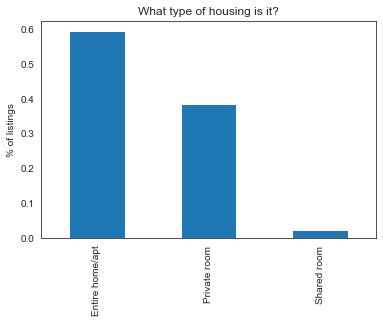

In [32]:
room_type_vals = listings_df['room_type'].value_counts()

(room_type_vals/listings_df.shape[0]).plot(kind="bar");
plt.title("What type of housing is it?");
plt.ylabel("% of listings");

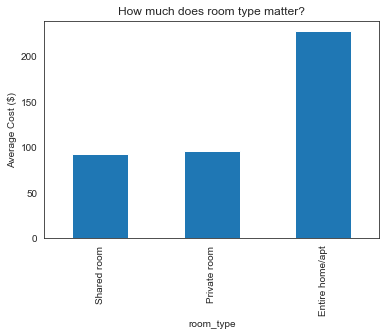

In [33]:
listings_df.groupby(['room_type']).mean()['price'].sort_values().plot(kind='bar');
plt.title("How much does room type matter?");
plt.ylabel("Average Cost ($)");

## Number of people listing can accommodate.
How much does the number of people who can share the room effect price? Very few listings allow more than 6 people.

Text(0, 0.5, '% of listings')

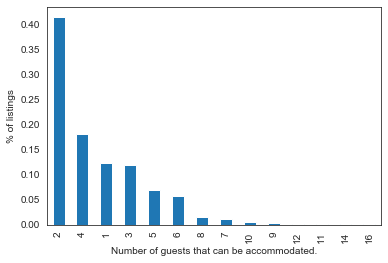

In [34]:
listings_vals = listings_df['accommodates'].value_counts()

(listings_vals/listings_df.shape[0]).plot(kind="bar")
plt.xlabel("Number of guests that can be accommodated.")
plt.ylabel("% of listings")

Drop the outliers with more than 10 people to accommodate.

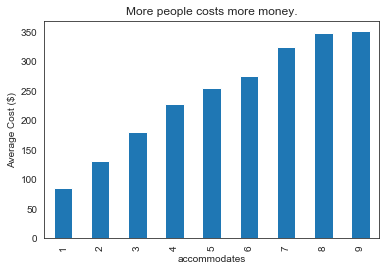

In [36]:
listings_df[listings_df['accommodates'] < 10].groupby(['accommodates']).mean()['price'].sort_values().plot(kind='bar');
plt.title("More people costs more money.");
plt.ylabel("Average Cost ($)");

However the price increase is not linear, as the cost per person is cheaper in a larger listing.

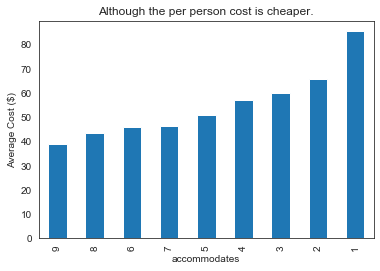

In [40]:
(listings_df[listings_df['accommodates'] < 10].groupby(['accommodates']).mean()['price']/listings_df[listings_df['accommodates'] < 10].groupby(['accommodates']).mean().index).sort_values().plot(kind='bar');
plt.title("Although the per person cost is cheaper.");
plt.ylabel("Average Cost ($)");

## Neighbourhods
Some neighbourhoods have more listings. Some neighbourhoods cost more money.

In [41]:
print('%f values missing from this column.' % (listings_df['neighbourhood'].isnull().mean()))

0.151464 values missing from this column.


Text(0, 0.5, 'Number of listings.')

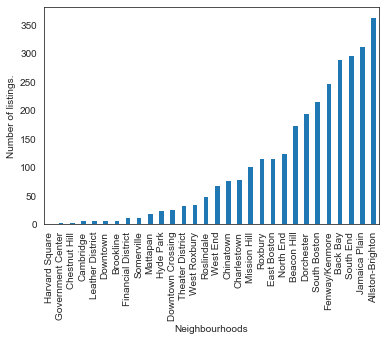

In [42]:
listings_df['neighbourhood'].dropna().value_counts().sort_values().plot(kind='bar')
plt.xlabel("Neighbourhoods")
plt.ylabel("Number of listings.")

Text(0, 0.5, 'Average price.')

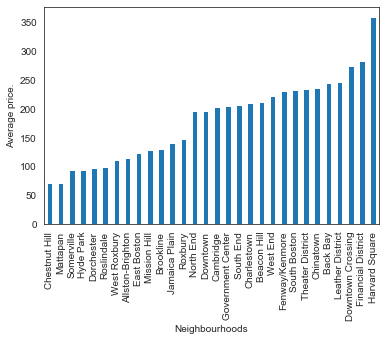

In [43]:
listings_df.groupby(['neighbourhood']).mean()['price'].sort_values().plot(kind='bar')
plt.xlabel("Neighbourhoods")
plt.ylabel("Average price.")

# Wrangling the Ammenities column

In [ ]:
def total_count(df, col1, col2, look_for):
    '''
    INPUT:
    df - the pandas dataframe you want to search
    col1 - the column name you want to look through
    col2 - the column you want to count values from
    look_for - a list of strings you want to search for in each row of df[col]

    OUTPUT:
    new_df - a dataframe of each look_for with the count of how often it shows up
    '''
    d = defaultdict(int)
    #loop through list of ed types
    for val in look_for:
        #loop through rows
        for idx in range(df.shape[0]):
            #if the ed type is in the row add 1
            if val in df[col1][idx]:
                new_df[val] += int(df[col2][idx])
                
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('count', ascending=False, inplace=True)
    return new_df

In [162]:
possible_vals = ["TV", "Cable TV","Air Conditioning","Kitchen",
                 "Heating","Washer","Dryer", "Gym", "Elevator in Building", "Family/Kid Friendly",
                 "Pool", "Internet"]

def clean_and_plot(df, title='', plot=True):
    '''
    INPUT 
        df - a dataframe holding the CousinEducation column
        title - string the title of your plot
        axis - axis object
        plot - bool providing whether or not you want a plot back
        
    OUTPUT
        study_df - a dataframe with the count of how many individuals
        Displays a plot of pretty things related to the CousinEducation column.
    '''
    study = df['amenities'].value_counts().reset_index()
    study.rename(columns={'index': 'amenity', 'amenities': 'count'}, inplace=True)
    study_df = total_count(study, 'amenity', 'count', possible_vals)

    study_df.set_index('amenity', inplace=True)
    if plot:
        study_df.plot(kind='bar', legend=None);
        plt.title(title);
        plt.show()
    props_study_df = study_df
    return props_study_df


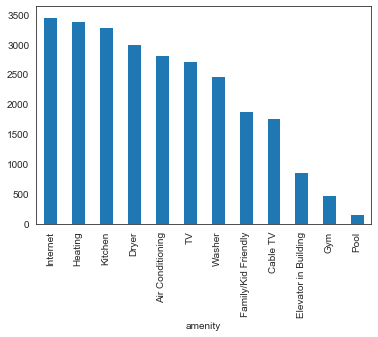

,count
amenity,
Internet,3459
Heating,3384
Kitchen,3284
Dryer,2993
Air Conditioning,2821
TV,2725
Washer,2475
Family/Kid Friendly,1888
Cable TV,1770


In [167]:
clean_and_plot(listings_df)